# Figures for "Systematically comparing feature-based representations of intra-regional and inter-regional brain dynamics"

## Load python packages

In [ ]:
import os
import numpy as np
import nibabel as nib
import pandas as pd
from nilearn import plotting
from nilearn.image import math_img, resample_img, index_img, threshold_img
from matplotlib import pyplot as plt

%load_ext rpy2.ipython

## Load R Packages

In [88]:
%%R 
library(broom)
library(circlize)
library(colorspace)
library(ComplexHeatmap)
library(correctR)
library(cowplot)
library(dendextend)
library(factoextra)
library(FactoMineR)
library(feather)
library(ggnewscale)
library(ggpp)
library(ggpubr)
library(ggraph)
library(ggridges)
library(ggseg)
library(ggsegDefaultExtra)
library(ggsegHO)
library(ggsignif)
library(glue)
library(icesTAF)
library(igraph)
library(LaCroixColoR)
library(patchwork)
library(R.matlab)
library(RColorBrewer)
library(rlist)
library(scales)
library(see)
library(splitstackshape)
library(theft)
library(tidyverse)
library(viridis)

# Set cowplot theme
theme_set(theme_cowplot())

## Load data needed for this analysis

In [90]:
# Load information about the time-series features
univariate_TS_feature_info = pd.read_csv("catch25_info.csv")
pairwise_TS_feature_info = pd.read_csv("SPI_info.csv")

# Define SVM kernel type
SVM_kernel = "Linear"

# Name the feature sets
univariate_feature_set = "catch25"
pairwise_feature_set = "pyspi14"

# Load study metadata
data_path = "/Users/abry4213/data/"

# Load participants included
UCLA_CNP_subjects_to_keep = pd.read_feather(f"{data_path}/UCLA_CNP/processed_data/UCLA_CNP_filtered_sample_info_AROMA_2P_GMR_catch25_pyspi14.feather")
UCLA_CNP_metadata = (pd.read_feather(f"{data_path}/UCLA_CNP/study_metadata/UCLA_CNP_sample_metadata.feather")
                        .assign(Study = "UCLA_CNP")
                        .query("Sample_ID in @UCLA_CNP_subjects_to_keep.Sample_ID"))
ABIDE_ASD_metadata = (pd.read_feather(f"{data_path}/ABIDE_ASD/study_metadata/ABIDE_ASD_sample_metadata.feather")
                        .assign(Study = "ABIDE_ASD"))

# Load intra-regional time-series features per disorder
UCLA_CNP_intra_regional_feature_data = (pd.read_feather(f"{data_path}/UCLA_CNP/processed_data/UCLA_CNP_AROMA_2P_GMR_catch25_filtered.feather")
                                        .merge(UCLA_CNP_metadata))
ABIDE_ASD_intra_regional_feature_data = (pd.read_feather(f"{data_path}/ABIDE_ASD/processed_data/ABIDE_ASD_FC1000_catch25_filtered.feather")
                                        .merge(ABIDE_ASD_metadata))

# Define path where data is stored
results_data_path = "/Users/abry4213/data/TS_feature_manuscript/"

# Load balanced accuracy scores
intra_regional_balanced_accuracy_all_folds = (pd.read_feather(f"{results_data_path}/UCLA_CNP_ABIDE_ASD_univariate_balanced_accuracy_all_folds.feather")
                                    .query("Univariate_Feature_Set == @univariate_feature_set & kernel == @SVM_kernel"))
inter_regional_balanced_accuracy_all_folds = (pd.read_feather(f"{results_data_path}/UCLA_CNP_ABIDE_ASD_pairwise_balanced_accuracy_all_folds.feather")
                                    .query("Pairwise_Feature_Set == @pairwise_feature_set"))
combined_balanced_accuracy_all_folds = (pd.read_feather(f"{results_data_path}/UCLA_CNP_ABIDE_ASD_combined_univariate_pairwise_balanced_accuracy_all_folds.feather")
                              .query("Univariate_Feature_Set == @univariate_feature_set & Pairwise_Feature_Set == @pairwise_feature_set")
                              .assign(Analysis_Type = "SPI_Univariate_Combo"))


FileNotFoundError: [Errno 2] No such file or directory: '/Users/abry4213/data//UCLA_CNP/processed_data/UCLA_CNP_AROMA_2P_GMR_catch25_filtered.feather'

In [ ]:
%%R -i intra_regional_balanced_accuracy_all_folds,inter_regional_balanced_accuracy_all_folds,combined_balanced_accuracy_all_folds -o UCLA_CNP_brain_region_info,ABIDE_ASD_brain_region_info,study_group_df,intra_regional_balanced_accuracy,inter_regional_balanced_accuracy,combined_balanced_accuracy

# Define study group dataframe
study_group_df <- data.frame(Study = c(rep("UCLA_CNP", 3), "ABIDE_ASD"),
                             Noise_Proc = c(rep("AROMA+2P+GMR",3), "FC1000"),
                             Comparison_Group = c("Schizophrenia", "Bipolar", "ADHD", "ASD"),
                             Group_Nickname = c("SCZ", "BP", "ADHD", "ASD"))

# Load brain region info
UCLA_CNP_brain_region_info <- read.csv("~/data/UCLA_CNP/study_metadata/UCLA_CNP_Brain_Region_info.csv")
ABIDE_ASD_brain_region_info <- read.table("~/data/ABIDE_ASD/study_metadata/ABIDE_ASD_Harvard_Oxford_cort_prob_2mm_ROI_lookup.txt", sep=";", header = T) %>%
  mutate(Brain_Region = ifelse(Index==45, "Heschl's Gyrus (includes H1 and H2)", Brain_Region))

# Aggregate balanced accuracy results across folds
intra_regional_balanced_accuracy <- intra_regional_balanced_accuracy_all_folds %>%
  group_by(Study, Comparison_Group, Univariate_Feature_Set, Analysis_Type, group_var, kernel) %>%
  reframe(Balanced_Accuracy_Across_Folds = mean(Balanced_Accuracy, na.rm=T),
          Balanced_Accuracy_Across_Folds_SD = sd(Balanced_Accuracy, na.rm=T))

inter_regional_balanced_accuracy <- inter_regional_balanced_accuracy_all_folds %>%
    group_by(Study, Comparison_Group, Pairwise_Feature_Set, Analysis_Type, group_var) %>%
    reframe(Balanced_Accuracy_Across_Folds = mean(Balanced_Accuracy, na.rm=T),
            Balanced_Accuracy_Across_Folds_SD = sd(Balanced_Accuracy, na.rm=T))

combined_balanced_accuracy <- combined_balanced_accuracy_all_folds %>%
    group_by(Study, Comparison_Group, Univariate_Feature_Set, Pairwise_Feature_Set, Analysis_Type, group_var) %>%
    reframe(Balanced_Accuracy_Across_Folds = mean(Balanced_Accuracy, na.rm=T),
            Balanced_Accuracy_Across_Folds_SD = sd(Balanced_Accuracy, na.rm=T))

In [ ]:
# Load p-values
intra_regional_p_values = (pd.read_feather(f"{results_data_path}/UCLA_CNP_ABIDE_ASD_univariate_empirical_p_values.feather")
                           .query("Univariate_Feature_Set == @univariate_feature_set")
                           .drop(columns=["Balanced_Accuracy_Across_Folds"])
                           .merge(intra_regional_balanced_accuracy))

inter_regional_p_values = (pd.read_feather(f"{results_data_path}/UCLA_CNP_ABIDE_ASD_pairwise_empirical_p_values.feather")
                            .query("Pairwise_Feature_Set == @pairwise_feature_set")
                            .drop(columns=["Balanced_Accuracy_Across_Folds"])
                            .merge(inter_regional_balanced_accuracy))

combined_p_values = (pd.read_feather(f"{results_data_path}/UCLA_CNP_ABIDE_ASD_combined_univariate_pairwise_empirical_p_values.feather")
                     .query("Univariate_Feature_Set == @univariate_feature_set & Pairwise_Feature_Set == @pairwise_feature_set")
                     .drop(columns=["Balanced_Accuracy_Across_Folds"])
                     .merge(combined_balanced_accuracy))


In [ ]:
%%R 
# Source helper functions
source("visualization_helper_functions.R")

# Figure 1: Methods

In [ ]:
%%R

# Plot an example brain
ggplot() +
  geom_brain(atlas = dk, hemi="left", side="lateral", color="gray30") +
  theme_void() + 
  theme(legend.position="none")


In [ ]:
%%R 

# Plot a few example time-series
example_MTS <- as.data.frame(matrix(data=rnorm(500), nrow=50, ncol=10)) %>%
  mutate(Timepoint = 1:50) %>%
  pivot_longer(cols=c(-Timepoint), names_to = "Brain_Region", values_to="BOLD") %>%
  mutate(Brain_Region = as.factor(as.numeric(gsub("V", "", Brain_Region))))

example_MTS %>%
  ggplot(mapping=aes(x=Timepoint, y=BOLD, color=Brain_Region)) +
  geom_line() + 
  facet_grid(Brain_Region ~ .) +
  theme_void() +
  theme(legend.position = "none",
        strip.text = element_blank(),
        panel.spacing = unit(-1, "lines"))


In [ ]:
%%R

# Plot as an example MTS heatmap
gg_color_hue <- function(n) {
  hues = seq(15, 375, length = n + 1)
  hcl(h = hues, l = 65, c = 100)[1:n]
}

MTS_heatmap_list <- list()
MTS_colors <- gg_color_hue(10)
for (i in 1:length(unique(example_MTS$Brain_Region))) {
  roi = unique(example_MTS$Brain_Region)[i]
  roi_color = MTS_colors[i]
  roi_p <- example_MTS %>%
    filter(Brain_Region == roi) %>%
    ggplot(mapping=aes(x=Timepoint, fill=BOLD, y=0)) +
    geom_tile() + 
    theme_void() +
    scale_fill_gradient(low=alpha(roi_color, 0.2), high=roi_color) +
    theme(legend.position = "none")
  MTS_heatmap_list[[roi]] <- roi_p
}
wrap_plots(MTS_heatmap_list, ncol=1)


In [ ]:
%%R
# Example brain with regions highlighted
dk %>%
  as_tibble() %>%
  mutate(fillval = case_when(label == "lh_caudalmiddlefrontal" ~ "1",
                             label == "lh_insula" ~ "2",
                             label == "lh_lateraloccipital" ~ "3", 
                             T ~ NA_character_)) %>%
  ggseg(atlas = "dk", mapping = aes(fill = fillval),
        hemisphere="left",
        view = "lateral",
        position = "stacked", colour = "gray50") +
  scale_fill_manual(values=c("#39b600", "#e76bf3", "#00b0f6"),
                    na.value="white") +
  theme_void() +
  theme(plot.title = element_blank(),
        legend.position = "none")


In [ ]:
%%R
# Sample feature vector
data.frame(x=sample(1:24),
           y=as.character(1:24)) %>%
  ggplot(data=., mapping=aes(x=x, y=0, fill=y)) +
  geom_tile(color="black") +
  scale_fill_viridis_d() +
  theme_void() +
  theme(legend.position = "none")

In [ ]:
%%R

# Brains with all 25 features [simulated data]
plot_feature_in_brain <- function(fill_color_gradient, region_label="all") {
  if (region_label=="all") {
    p <- dk %>%
      as_tibble() %>%
      mutate(region_values = runif(nrow(.))) %>%
      ggseg(atlas = "dk", mapping = aes(fill = region_values),
            hemisphere="left",
            view = "lateral",
            position = "stacked", colour = "black") +
      scale_fill_gradientn(colors=c(alpha(fill_color_gradient, 0.3), 
                                    fill_color_gradient), 
                           na.value=NA)
  } else {
    p <- dk %>%
      as_tibble() %>%
      mutate(region_values = ifelse(label==region_label, "1", NA_character_)) %>%
      ggseg(atlas = "dk", mapping = aes(fill = region_values),
            hemisphere="left",
            view = "lateral",
            position = "stacked", colour = "gray40") +
      scale_fill_manual(values=c(fill_color_gradient),
                        na.value="white")
  }

  p <- p  +
    theme_void() +
    theme(plot.title = element_blank(),
          legend.position = "none") 
}


# Plot the full brain
plots <- sample(1:25) %>%
  purrr::map(~ plot_feature_in_brain(fill_color_gradient=brain_colors[.x], 
                                     region_label="all"))
wrap_plots(plots, nrow=5)

In [ ]:
%%R

# Plot feature X region matrix
feature_vec_plot_list <- list()
for (i in sample(1:25)) {
  p <- data.frame(x=sample(1:10),
             y=as.character(1:10)) %>%
    ggplot(data=., mapping=aes(x=y, y=0, fill=x)) +
    geom_raster(color="black") +
    scale_fill_gradientn(colors=c(alpha(brain_colors[i], 0.3), 
                                  brain_colors[i]), 
                         na.value=NA) +
    theme_void() +
    theme(legend.position = "none")
  feature_vec_plot_list <- list.append(feature_vec_plot_list, p)
}

wrap_plots(feature_vec_plot_list, ncol=1)

In [ ]:
%%R
# Sample pairwise feature vector
pyspi_colors <- unname(lacroix_palette("PassionFruit",14))
data.frame(x=sample(1:14),
           y=as.character(1:14)) %>%
  ggplot(data=., mapping=aes(x=x, y=0, fill=y)) +
  geom_tile(color="black") +
  scale_fill_manual(values=pyspi_colors) +
  theme_void() +
  theme(legend.position = "none")

In [ ]:
%%R

# Example network graph
set.seed(127)

# Data for all pairwise connection graphs
# Edges are defined as cortical lobe --> specific ROI connection
edges <- read.csv("region_node_hierarchy.csv") %>% distinct()
# ROIs don't include the origin --> cortical lobe connection
rois <- edges %>% filter(!(to %in% c("Cingulate", "Frontal", "Insula",
                                     "Occipital", "Parietal", "Temporal")))
# Create a dataframe of vertices, one line per object in the ROI cortical lobe hierarchy
vertices = data.frame(name = unique(c(as.character(edges$from), as.character(edges$to))))
vertices$group <- edges$from[match(vertices$name, edges$to)]
# Create an igraph object
mygraph <- graph_from_data_frame(edges, vertices=vertices)

# plot_network_data is defined in visualization_helper_functions.R
plots <- sample(1:14) %>%
  purrr::map(~ plot_network_data(pyspi_colors[.x]))
wrap_plots(plots, nrow=3)

# Figure 2: Local properties of BOLD dynamics in individual brain regions can meaningfully distinguish cases versus controls

In [ ]:
%%R -i intra_regional_p_values -o significant_univariate_region_wise_results

# Define dataset with univariate region-wise results
significant_univariate_region_wise_results <- intra_regional_p_values %>%
  filter(Analysis_Type == "Univariate_Brain_Region") %>%
  filter(p_value_HolmBonferroni < 0.05) %>%
  mutate(Balanced_Accuracy_Across_Folds = 100*Balanced_Accuracy_Across_Folds)

catch25_region_wise_balacc_plot_list <- plot_balacc_in_brain(significant_univariate_region_wise_results,
                                                             bin_seq_range=seq(50,75,by=5))
wrap_plots(catch25_region_wise_balacc_plot_list, 
           ncol=2, 
           byrow=T) + 
  plot_layout(guides = "collect")

In [ ]:
%%R 
# We can get the number of significant regions per disorder
significant_univariate_region_wise_results %>%
  count(Comparison_Group)

# Figure 3: Analysis with individual time-series features measured across the brain highlights diverse differences in brain-wide dynamics across clinical groups

Joining with `by = join_by(feature_name)`


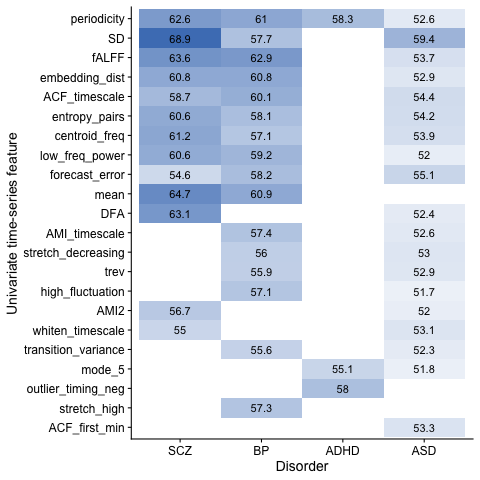

In [89]:
%%R -i intra_regional_p_values,univariate_TS_feature_info,univariate_feature_set

# Balanced accuracy heatmap
intra_regional_p_values %>%
  filter(Univariate_Feature_Set == univariate_feature_set,
         Analysis_Type == "Univariate_TS_Feature") %>%
  dplyr::rename("feature_name" = "group_var") %>%
  left_join(., univariate_TS_feature_info) %>%
  filter(p_value_HolmBonferroni<0.05) %>%
  mutate(Comparison_Group = case_when(Comparison_Group == "Schizophrenia" ~ "SCZ",
                                      Comparison_Group == "Bipolar" ~ "BP",
                                      T ~ Comparison_Group),
         Balanced_Accuracy_Across_Folds = 100*Balanced_Accuracy_Across_Folds) %>%
  mutate(Figure_name = fct_reorder(Figure_name, Balanced_Accuracy_Across_Folds, .fun=sum),
         Comparison_Group = factor(Comparison_Group, levels = c("SCZ", "BP", "ADHD", "ASD"))) %>%
  ggplot(data=., mapping=aes(x=Comparison_Group, y=Figure_name, 
                             fill=Balanced_Accuracy_Across_Folds)) +
  geom_tile()+
  geom_text(aes(label = round(Balanced_Accuracy_Across_Folds, 1))) +
  scale_fill_gradientn(colors=c(alpha("#4C7FC0", 0.1), "#4C7FC0"), 
                       na.value=NA) +
  labs(fill = "Mean Balanced Accuracy (%)") +
  xlab("Disorder") +
  ylab("Univariate time-series feature") +
  theme(legend.position="none",
        strip.background = element_blank(),
        strip.text = element_blank())

In [ ]:
%%R -i intra_regional_p_values,univariate_TS_feature_info,univariate_feature_set

# Create adjacency matrix of feature values across all participants
top_features <- intra_regional_p_values %>%
  filter(Univariate_Feature_Set == univariate_feature_set,
         Analysis_Type == "Univariate_TS_Feature") %>%
  group_by(group_var) %>%
  filter(sum(p_value_HolmBonferroni<0.05)>=3) %>%
  summarise(sum_balacc = sum(Balanced_Accuracy_Across_Folds)) %>%
  slice_max(sum_balacc, n=10) %>%
  pull(group_var)

data_for_corr_heatmap <- plyr::rbind.fill(UCLA_CNP_catch25, ABIDE_ASD_catch25) %>%
  filter(names %in% top_features) %>%
  mutate(unique_ID = paste0(Sample_ID, "__", Brain_Region), .keep="unused") %>%
  left_join(., TS_feature_info, by=c("names"="feature_name")) %>%
  dplyr::select(unique_ID, Figure_name, values) %>%
  pivot_wider(id_cols=unique_ID, names_from=Figure_name, values_from=values) %>%
  dplyr::select(-unique_ID) %>%
  cor(method="spearman", use="complete.obs") %>%
  abs()

# Convert to long for easy querying
data_for_corr_long <- data_for_corr_heatmap %>%
  as.data.frame() %>%
  rownames_to_column(var="feature1") %>%
  pivot_longer(cols=c(-feature1), names_to="feature2", values_to="spearman_corr_abs")

num_branches <- 2

ht1 <- ComplexHeatmap::Heatmap(data_for_corr_heatmap,
                               clustering_distance_rows = "spearman",
                               clustering_distance_columns = "spearman",
                               clustering_method_rows = "average",
                               clustering_method_columns = "average",
                               row_names_side = "right",
                               row_dend_side = "left", 
                               row_dend_width = unit(1, "cm"),
                               row_dend_gp = gpar(lwd=unit(2, "cm")),
                               row_split = num_branches,
                               column_split = num_branches,
                               column_gap = unit(3, "mm"),
                               row_title = NULL,
                               column_title = NULL,
                               show_row_names = TRUE,
                               show_column_names = FALSE,
                               show_column_dend = FALSE,
                               border = TRUE,
                               col = c("white", brewer.pal(12, "Reds")),
                               name = "Spearman rank correlation, \u03c1",
                               heatmap_legend_param = list(legend_direction = "horizontal",
                                                           legend_width = unit(5, "cm")))